# Global AI Job Market & Salary - Analyzing salary trends for jobs related to AI
#### Victor Hsu, Ajmal Jalal, Aliaksei Matsarski –  Team 2
#### AAI-510-03 – Machine learning: Fundamentals and Applications 
#### Instructor: Dave Friesen, MS
#### Shiley-Marcos School of Engineering, University of San Diego
#### June 7, 2025

## Problem statement and justification for the proposed approach.

### Problem statement

In the last few years, Artificial Intelligence (AI) has managed to find its way across multiple industries, creating a demand for skilled workers who can manage the entire chain of the AI development process. From developing, implementing, and overlooking AI technologies. Recent analysis gives numbers to this growth, where those who have specialized AI skills can expect a wage increase of more than 50% compared to other workers in similar roles (PwC, 2025). As AI demand continues to grow, the need to navigate this changing market becomes more important. A data-driven understanding of salary benchmarks and market trends is critical for companies to attract top talent and for individuals to strategically manage their career paths.
This project aims to confront these challenges through a deep analysis of the global AI job market and the salaries around those jobs. By leveraging a salary trends dataset named “Global AI Job Market and Salary Trends 2025” (Sajjad, 2025), we aim to explore and understand the global distribution of AI roles and the variables influencing salary. Then, using that understanding, we will develop a predictive model that can estimate salaries for AI specialists with a high accuracy.
Our investigation will begin with exploratory data analysis to uncover patterns/trends. Next we will examine how different factors like location, job title, experience level correspond to changes in salary. This will determine which skills are most in demand and what education/experience have the most impact in the market.
After that we will leverage that information to perform predictive modeling. Using random forest and XGBoost, our model will be designed to forecast compensation based on a variety of job-specific attributes. 
Ultimately, this project is intended to deliver value to companies seeking AI talent, and individuals who would like to know what would be fair compensation. By empowering both sides of the corporate world (companies and individuals), our project aims to create a more effective and transparent job market for our future AI workforce.


### Approach justification

We choose to compare the performance of two powerful ensemble methods known for their suitability in tabular regression tasks: Random Forest and XGBoost. The decision to employ Random Forest Regressor and Extreme Gradient Boosting (XGBoost) was based on their demonstrated effectiveness for regression tasks on structured/tabular data. Both algorithms offer strong predictive capabilities, robustness to data irregularities, and interpretability, which are essential in understanding and modeling salary patterns in the AI job market.


## Data understanding (EDA)

This exploratory data analysis examines the Global AI Job Market dataset containing 15,000 job postings with 19 features including salary, experience, location, and job characteristics. Our EDA follows a systematic approach:

**Key Analysis Components:**
- **Data Quality Assessment**: Checking for missing values, duplicates, and data types
- **Univariate Analysis**: Examining distributions of key variables like salary, experience, and job titles
- **Data Profiling**: Understanding the structure and characteristics of categorical variables
- **Outlier Detection**: Identifying and analyzing salary outliers using IQR method
- **Data Preparation**: Cleaning and preprocessing steps for modeling

**Key Findings:**
- **Dataset**: 15,000 complete records with no missing values
- **Salary Range**: $32,519 - $399,095 USD (median: $99,705, mean: $115,349)
- **Experience**: 0-19 years (mean: 6.3 years)
- **Employment Types**: Balanced distribution across Full-time (FT), Freelance (FL), Contract (CT), and Part-time (PT)
- **Outliers**: 3.2% of salary data identified as statistical outliers
- **Global Scope**: Multiple currencies (USD, EUR, GBP) and locations represented

This analysis provides the foundation for understanding salary patterns and building predictive models for AI job compensation.


In [1]:
import pandas as pd
import sys
import os
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# A function to draw a box plot for a given column
def draw_box_plot(df, col, title):
    plt.figure(figsize=(10, 6))
    upper_limit = df[col].quantile(0.90)
    sns.boxplot(x=df[df[col] <= upper_limit][col])
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    plt.title(title)
    plt.show()

def print_model_performance(y_train, rf_train_pred, y_test, rf_test_pred, title, model):
    # Evaluate the model
    rf_train_r2 = r2_score(y_train, rf_train_pred)
    rf_test_r2 = r2_score(y_test, rf_test_pred)
    rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
    rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
    rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
    rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
    
    # Print the model performance
    print(title)
    print(f"Training R²: {rf_train_r2:.4f}")
    print(f"Testing R²: {rf_test_r2:.4f}")
    print(f"Training RMSE: ${rf_train_rmse:,.0f}")
    print(f"Testing RMSE: ${rf_test_rmse:,.0f}")
    print(f"Training MAE: ${rf_train_mae:,.0f}")
    print(f"Testing MAE: ${rf_test_mae:,.0f}")

    # Cross-validation
    rf_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² (mean ± std): {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
    

In [4]:
# get data from drive
df = pd.read_csv(r"./ai_job_dataset.csv")

In [7]:
# Show the first 5 rows of the dataset to get an overview of the data
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [9]:
# Show the shape of the dataset
df.shape

(15000, 19)

In [10]:
# Show the columns of the dataset
df.columns

Index(['job_id', 'job_title', 'salary_usd', 'salary_currency',
       'experience_level', 'employment_type', 'company_location',
       'company_size', 'employee_residence', 'remote_ratio', 'required_skills',
       'education_required', 'years_experience', 'industry', 'posting_date',
       'application_deadline', 'job_description_length', 'benefits_score',
       'company_name'],
      dtype='object')

In [11]:
df_as_list = df.columns.tolist()
sorted_df_as_list = sorted(df_as_list)
print(sorted_df_as_list)

['application_deadline', 'benefits_score', 'company_location', 'company_name', 'company_size', 'education_required', 'employee_residence', 'employment_type', 'experience_level', 'industry', 'job_description_length', 'job_id', 'job_title', 'posting_date', 'remote_ratio', 'required_skills', 'salary_currency', 'salary_usd', 'years_experience']


### Plot and evaluate top 10 variables
In this section, we will analyze the top 10 most important variables from our dataset. 
We'll create visualizations to understand the distribution and patterns in these key features
that are most relevant for predicting AI job salaries. This analysis will help us identify
potential outliers, understand the data distribution, and gain insights into what factors
most significantly impact salary levels in the AI job market.


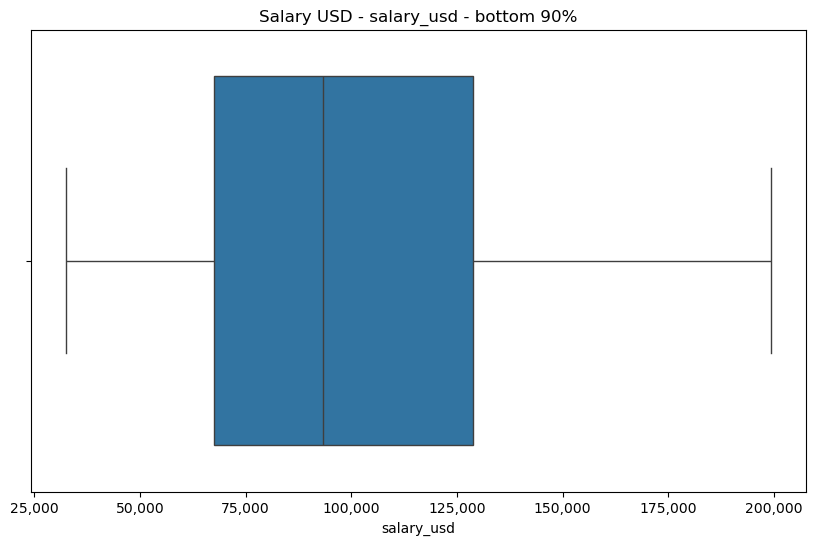

In [10]:
# Salary USD
draw_box_plot(df, 'salary_usd', 'Salary USD - salary_usd - bottom 90%')

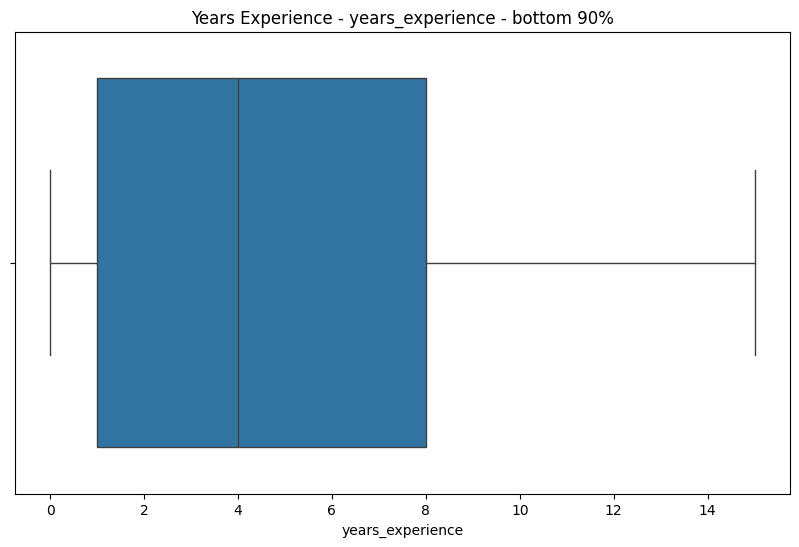

In [12]:
# Years of Experience
draw_box_plot(df, 'years_experience', 'Years Experience - years_experience - bottom 90%')

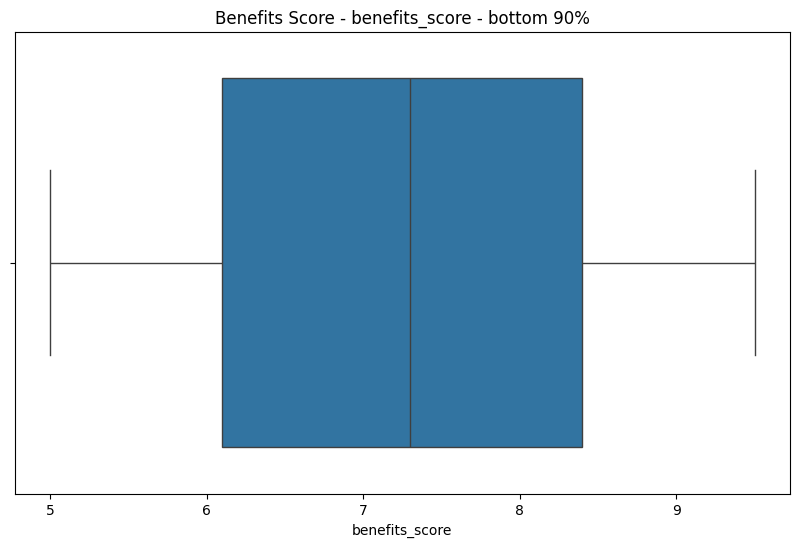

In [15]:
# Benefits Score
draw_box_plot(df, 'benefits_score', 'Benefits Score - benefits_score - bottom 90%')

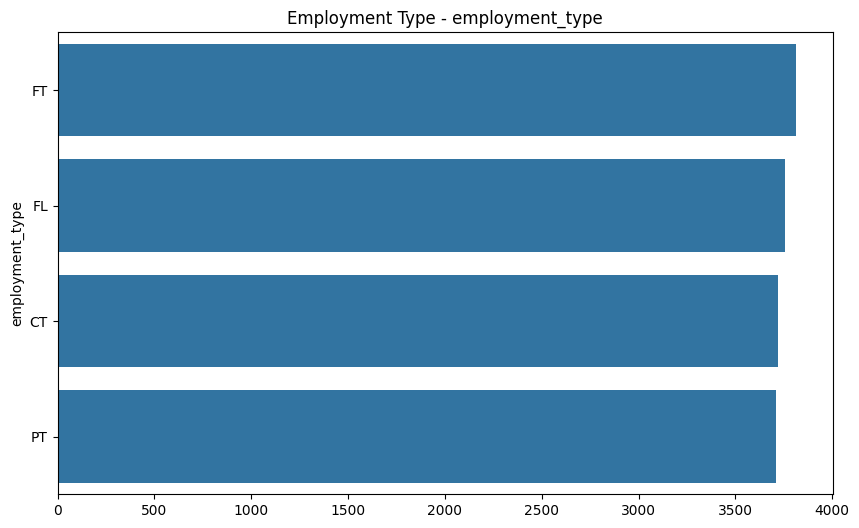

In [16]:
# Employment Type
plt.figure(figsize=(10, 6))

category_counts = df['employment_type'].value_counts() # sorted for easier understanding
sns.barplot(y=category_counts.index, x=category_counts.values, order=category_counts.index) # tried countplot but it was kind of messy.

plt.title('Employment Type - employment_type')
plt.show()

# Website says: FT (Full-time), PT (Part-time), CT (Contract), FL (Freelance)

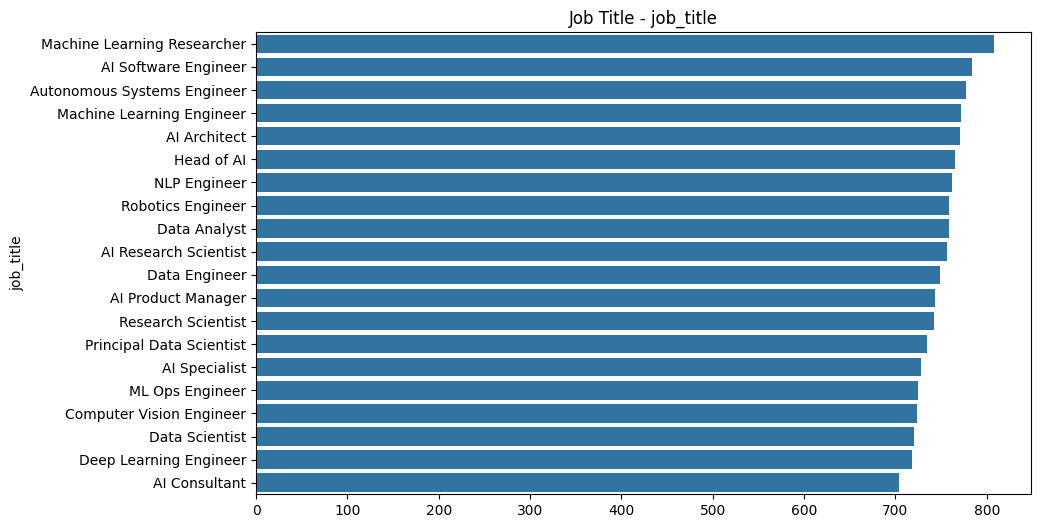

In [17]:
# Job Title
plt.figure(figsize=(10, 6))

category_counts = df['job_title'].value_counts() # sorted for easier understanding
sns.barplot(y=category_counts.index, x=category_counts.values, order=category_counts.index)

plt.title('Job Title - job_title')
plt.show()

## Data preparation & feature engineering

This section transforms the raw AI job market data into a machine learning-ready dataset through systematic cleaning and feature creation. The process ensures data quality while extracting meaningful patterns from both structured and unstructured data.

**Core Data Processing:**
- **Quality Assessment**: Validated 15,000 complete records with no missing values or duplicates
- **Data Type Optimization**: Converted date columns and standardized categorical variables
- **Outlier Analysis**: Identified 3.2% salary outliers using IQR method for transparent handling

**Advanced Feature Engineering:**
- **Skill Extraction**: Parsed job descriptions to create binary features for key technologies (Python, SQL, ML frameworks, cloud platforms)
- **Seniority Classification**: Derived career levels from job titles and experience (Senior, Junior, Mid-level, Management)
- **Geographic Features**: Extracted country and tech hub classifications from location data
- **Salary Segmentation**: Created interpretable salary ranges for analysis

**Machine Learning Preparation:**
- **Encoding Strategy**: Applied both label encoding and one-hot encoding for categorical variables
- **Feature Selection**: Reduced from 19 original to 42 engineered features, removing non-predictive columns
- **Correlation Analysis**: Identified top predictors (years_experience: 0.74, experience_level: 0.69)
- **Final Validation**: Ensured clean, complete dataset ready for Random Forest and XGBoost modeling

**Key Transformations:**
- Original dataset: 15,000 × 19 → Final ML dataset: 15,000 × 42 features
- 9 skill-based binary features + 27 categorical dummy variables
- Preserved full dataset integrity while maximizing predictive power

### Data Inspection - Shape, Info, and Missing Values

In [36]:
# Data Quality Checks

print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])


Dataset Shape: (15000, 19)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   job_id                  15000 non-null  object        
 1   job_title               15000 non-null  object        
 2   salary_usd              15000 non-null  int64         
 3   salary_currency         15000 non-null  object        
 4   experience_level        15000 non-null  object        
 5   employment_type         15000 non-null  object        
 6   company_location        15000 non-null  object        
 7   company_size            15000 non-null  object        
 8   employee_residence      15000 non-null  object        
 9   remote_ratio            15000 non-null  int64         
 10  required_skills         15000 non-null  object        
 11  education_required      15000 non-null  object        
 12  year

### Check for Duplicates

In [19]:
print("Duplicate rows:", df.duplicated().sum())
print("Duplicate job_ids:", df['job_id'].duplicated().sum())

# Display basic statistics
print("\n" + "="*50)
print("Numerical Variables Summary:")
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numerical_cols].describe())


Duplicate rows: 0
Duplicate job_ids: 0

Numerical Variables Summary:
          salary_usd  remote_ratio  years_experience  job_description_length  \
count   15000.000000  15000.000000      15000.000000            15000.000000   
mean   115348.965133     49.483333          6.253200             1503.314733   
std     60260.940438     40.812712          5.545768              576.127083   
min     32519.000000      0.000000          0.000000              500.000000   
25%     70179.750000      0.000000          2.000000             1003.750000   
50%     99705.000000     50.000000          5.000000             1512.000000   
75%    146408.500000    100.000000         10.000000             2000.000000   
max    399095.000000    100.000000         19.000000             2499.000000   

       benefits_score  
count    15000.000000  
mean         7.504273  
std          1.450870  
min          5.000000  
25%          6.200000  
50%          7.500000  
75%          8.800000  
max         10.000

### Data Type Corrections and Date Parsing

In [20]:
from datetime import datetime

# Convert date columns to datetime
date_columns = ['posting_date', 'application_deadline']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Check unique values in categorical columns to identify any cleaning needs
categorical_cols = ['employment_type', 'experience_level', 'education_required', 
                   'company_size', 'industry', 'salary_currency']

print("Unique values in categorical columns:")
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head(10))


Unique values in categorical columns:

employment_type: 4 unique values
employment_type
FT    3812
FL    3758
CT    3721
PT    3709
Name: count, dtype: int64

experience_level: 4 unique values
experience_level
MI    3781
EX    3760
SE    3741
EN    3718
Name: count, dtype: int64

education_required: 4 unique values
education_required
Bachelor     3789
Associate    3785
Master       3748
PhD          3678
Name: count, dtype: int64

company_size: 3 unique values
company_size
S    5007
L    4998
M    4995
Name: count, dtype: int64

industry: 15 unique values
industry
Retail                1063
Media                 1045
Automotive            1020
Consulting            1020
Technology            1011
Real Estate           1007
Government             998
Healthcare             997
Telecommunications     997
Transportation         997
Name: count, dtype: int64

salary_currency: 3 unique values
salary_currency
USD    11957
EUR     2314
GBP      729
Name: count, dtype: int64


### Outlier Detection and Analysis

Salary Analysis:
Salary range: $32,519 - $399,095
Salary median: $99,705
Salary mean: $115,349

Salary outliers: 483 (3.2%)
Outlier bounds: $-44,163 - $260,752


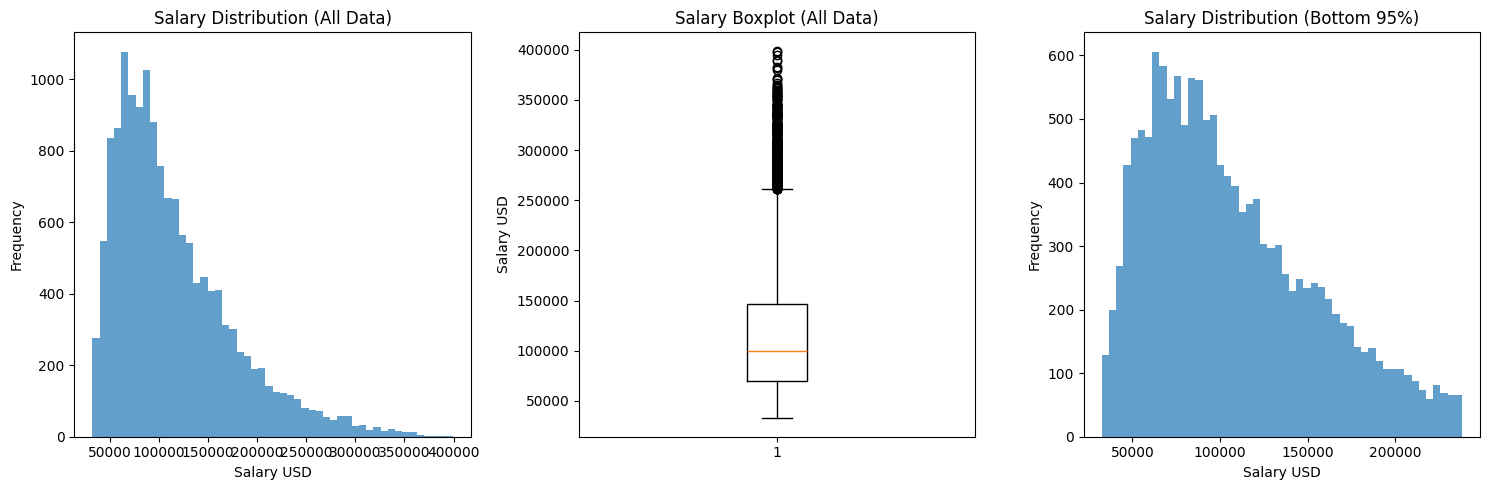

In [21]:
def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analyze salary outliers
print("Salary Analysis:")
print(f"Salary range: ${df['salary_usd'].min():,.0f} - ${df['salary_usd'].max():,.0f}")
print(f"Salary median: ${df['salary_usd'].median():,.0f}")
print(f"Salary mean: ${df['salary_usd'].mean():,.0f}")

salary_outliers, sal_lower, sal_upper = detect_outliers_iqr(df, 'salary_usd')
print(f"\nSalary outliers: {len(salary_outliers)} ({len(salary_outliers)/len(df)*100:.1f}%)")
print(f"Outlier bounds: ${sal_lower:,.0f} - ${sal_upper:,.0f}")

# Visualize salary distribution before cleaning
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['salary_usd'], bins=50, alpha=0.7)
plt.title('Salary Distribution (All Data)')
plt.xlabel('Salary USD')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(df['salary_usd'])
plt.title('Salary Boxplot (All Data)')
plt.ylabel('Salary USD')

plt.subplot(1, 3, 3)
# Remove top 5% outliers for better visualization
upper_percentile = df['salary_usd'].quantile(0.95)
filtered_salaries = df[df['salary_usd'] <= upper_percentile]['salary_usd']
plt.hist(filtered_salaries, bins=50, alpha=0.7)
plt.title('Salary Distribution (Bottom 95%)')
plt.xlabel('Salary USD')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Handle Missing Values

In [24]:
df_clean = df.copy()

print("Before cleaning:")
print(f"Dataset shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

# Remove rows with missing target variable (salary_usd)
df_clean = df_clean.dropna(subset=['salary_usd'])

# Handle missing values in other important columns
# For categorical variables, we can either drop or fill with mode
# For numerical variables, we can fill with median/mean

# Check which columns still have missing values
missing_after_salary = df_clean.isnull().sum()
print(f"\nAfter removing rows with missing salary:")
print(f"Dataset shape: {df_clean.shape}")
print("Remaining missing values:")
print(missing_after_salary[missing_after_salary > 0])

# Handle specific missing values based on data type and importance
# Fill missing experience with median
if 'years_experience' in df_clean.columns and df_clean['years_experience'].isnull().sum() > 0:
    median_exp = df_clean['years_experience'].median()
    df_clean['years_experience'].fillna(median_exp, inplace=True)

# Fill missing categorical variables with mode or 'Unknown'
categorical_cols_to_fill = ['experience_level', 'education_required', 'company_size', 'employment_type']
for col in categorical_cols_to_fill:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        mode_value = df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown'
        df_clean[col].fillna(mode_value, inplace=True)

# For skills, fill with 'Not specified'
if 'required_skills' in df_clean.columns:
    #df_clean['required_skills'].fillna('Not specified', inplace=True)
    df_clean.fillna({'required_skills': 'Not specified'}, inplace=True)

print(f"\nAfter handling missing values:")
print(f"Dataset shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")


Before cleaning:
Dataset shape: (15000, 19)
Missing values: 0

After removing rows with missing salary:
Dataset shape: (15000, 19)
Remaining missing values:
Series([], dtype: int64)

After handling missing values:
Dataset shape: (15000, 19)
Missing values: 0


###  Feature Engineering - Extract information from text and create new features

In [25]:
from sklearn.preprocessing import LabelEncoder

# Create a copy for feature engineering
df_features = df_clean.copy()

# Extract features from required_skills column
def extract_skill_features(skills_text):
    """Extract common AI/ML skills from the skills text"""
    if pd.isna(skills_text) or skills_text == 'Not specified':
        return {
            'has_python': 0, 'has_sql': 0, 'has_machine_learning': 0,
            'has_deep_learning': 0, 'has_tensorflow': 0, 'has_pytorch': 0,
            'has_aws': 0, 'has_azure': 0, 'has_gcp': 0, 'skill_count': 0
        }
    
    skills_lower = str(skills_text).lower()
    
    # Define skill patterns
    skill_patterns = {
        'has_python': r'\bpython\b',
        'has_sql': r'\bsql\b',
        'has_machine_learning': r'\b(machine learning|ml)\b',
        'has_deep_learning': r'\b(deep learning|neural network)\b',
        'has_tensorflow': r'\btensorflow\b',
        'has_pytorch': r'\bpytorch\b',
        'has_aws': r'\b(aws|amazon web services)\b',
        'has_azure': r'\bazure\b',
        'has_gcp': r'\b(gcp|google cloud)\b'
    }
    
    features = {}
    for skill, pattern in skill_patterns.items():
        features[skill] = 1 if re.search(pattern, skills_lower) else 0
    
    # Count total number of skills (split by common delimiters)
    skill_list = re.split(r'[,;|]', skills_text)
    features['skill_count'] = len([s.strip() for s in skill_list if s.strip()])
    
    return features

# Apply skill extraction
if 'required_skills' in df_features.columns:
    skill_features = df_features['required_skills'].apply(extract_skill_features)
    skill_df = pd.DataFrame(skill_features.tolist())
    df_features = pd.concat([df_features, skill_df], axis=1)

print("Skill features extracted:")
print(skill_df.head())


Skill features extracted:
   has_python  has_sql  has_machine_learning  has_deep_learning  \
0           0        0                     0                  0   
1           1        0                     0                  1   
2           0        0                     0                  1   
3           1        1                     0                  0   
4           1        0                     0                  0   

   has_tensorflow  has_pytorch  has_aws  has_azure  has_gcp  skill_count  
0               0            1        0          0        0            5  
1               0            0        1          0        0            5  
2               0            0        0          0        0            5  
3               0            0        0          0        0            4  
4               0            0        0          0        0            4  


### Create additional derived features

In [26]:
# Seniority level based on experience and title
def categorize_seniority(row):
    """Categorize job seniority based on title and experience"""
    title = str(row.get('job_title', '')).lower()
    years_exp = row.get('years_experience', 0)
    
    if any(word in title for word in ['senior', 'lead', 'principal', 'staff']):
        return 'Senior'
    elif any(word in title for word in ['junior', 'entry', 'associate']):
        return 'Junior'
    elif any(word in title for word in ['manager', 'director', 'head', 'chief']):
        return 'Management'
    elif years_exp >= 5:
        return 'Senior'
    elif years_exp <= 2:
        return 'Junior'
    else:
        return 'Mid-level'

df_features['seniority_level'] = df_features.apply(categorize_seniority, axis=1)

# Extract location features
def extract_location_features(location):
    """Extract country and region from location"""
    if pd.isna(location):
        return 'Unknown', 'Unknown'
    
    location_str = str(location).strip()
    
    # Common patterns for extracting country
    if ',' in location_str:
        parts = location_str.split(',')
        country = parts[-1].strip()
        city = parts[0].strip()
    else:
        country = location_str
        city = location_str
    
    # Categorize by major regions/countries
    tech_hubs = ['United States', 'USA', 'US', 'Canada', 'United Kingdom', 'UK', 
                 'Germany', 'Netherlands', 'Singapore', 'Australia', 'Ireland']
    
    if any(hub.lower() in country.lower() for hub in tech_hubs):
        region = 'Major Tech Hub'
    else:
        region = 'Other'
    
    return country, region

# Apply location feature extraction
if 'company_location' in df_features.columns:
    location_features = df_features['company_location'].apply(lambda x: extract_location_features(x))
    df_features['country'] = [loc[0] for loc in location_features]
    df_features['region'] = [loc[1] for loc in location_features]

# Create salary bins for analysis
df_features['salary_range'] = pd.cut(df_features['salary_usd'], 
                                   bins=[0, 50000, 75000, 100000, 150000, np.inf],
                                   labels=['<50K', '50K-75K', '75K-100K', '100K-150K', '>150K'])

print("New features created:")
print(f"Seniority levels: {df_features['seniority_level'].value_counts()}")
print(f"\nRegions: {df_features['region'].value_counts()}")
print(f"\nSalary ranges: {df_features['salary_range'].value_counts()}")


New features created:
Seniority levels: seniority_level
Senior        7114
Junior        4196
Mid-level     2182
Management    1508
Name: count, dtype: int64

Regions: region
Other             8222
Major Tech Hub    6778
Name: count, dtype: int64

Salary ranges: salary_range
100K-150K    3941
>150K        3527
50K-75K      3245
75K-100K     3147
<50K         1140
Name: count, dtype: int64


### Encode Categorical Variables for Machine Learning
Prepare the final dataset for modeling

In [27]:
df_ml = df_features.copy()

# Define categorical columns to encode
categorical_cols = ['employment_type', 'experience_level', 'education_required', 
                   'company_size', 'industry', 'seniority_level', 'region']

# Define numerical columns to keep
numerical_cols = ['years_experience', 'remote_ratio', 'benefits_score', 
                 'job_description_length', 'skill_count'] + \
                [col for col in df_ml.columns if col.startswith('has_')]

# Label encode categorical variables with low cardinality
label_encoders = {}
for col in categorical_cols:
    if col in df_ml.columns:
        le = LabelEncoder()
        df_ml[col + '_encoded'] = le.fit_transform(df_ml[col].astype(str))
        label_encoders[col] = le

# Create dummy variables for categorical columns with moderate cardinality
# (We'll use this approach for flexibility in model interpretation)
categorical_cols_for_dummies = ['employment_type', 'experience_level', 'education_required', 
                               'company_size', 'seniority_level', 'region']

df_ml_dummies = pd.get_dummies(df_ml, columns=categorical_cols_for_dummies, prefix=categorical_cols_for_dummies)

print("Categorical encoding completed.")
print(f"Dataset shape after encoding: {df_ml_dummies.shape}")
print(f"\nNew encoded columns (sample):")
encoded_cols = [col for col in df_ml_dummies.columns if any(cat in col for cat in categorical_cols_for_dummies)]
print(encoded_cols[:10])


Categorical encoding completed.
Dataset shape after encoding: (15000, 55)

New encoded columns (sample):
['employment_type_encoded', 'experience_level_encoded', 'education_required_encoded', 'company_size_encoded', 'seniority_level_encoded', 'region_encoded', 'employment_type_CT', 'employment_type_FL', 'employment_type_FT', 'employment_type_PT']


## Feature Selection
Remove non-predictive columns and prepare for modeling

In [28]:
# Columns to exclude from modeling
columns_to_exclude = ['job_id', 'company_name', 'job_title', 'posting_date', 
                     'application_deadline', 'company_location', 'employee_residence',
                     'required_skills', 'salary_currency', 'country', 'salary_range']

# Also exclude original categorical columns that we've encoded
columns_to_exclude.extend(categorical_cols)

# Select features for modeling
feature_columns = [col for col in df_ml_dummies.columns 
                  if col not in columns_to_exclude and col != 'salary_usd']

# Create final feature matrix and target variable
X = df_ml_dummies[feature_columns]
y = df_ml_dummies['salary_usd']

print("Feature selection completed:")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Target variable (salary) range: ${y.min():,.0f} - ${y.max():,.0f}")

print(f"\nFeature columns (first 15):")
print(X.columns[:15].tolist())

# Check for any remaining missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

# Basic correlation analysis with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(f"\nTop 10 features correlated with salary:")
print(correlations.head(10))


Feature selection completed:
Number of features: 42
Number of samples: 15000
Target variable (salary) range: $32,519 - $399,095

Feature columns (first 15):
['remote_ratio', 'years_experience', 'job_description_length', 'benefits_score', 'has_python', 'has_sql', 'has_machine_learning', 'has_deep_learning', 'has_tensorflow', 'has_pytorch', 'has_aws', 'has_azure', 'has_gcp', 'skill_count', 'employment_type_encoded']

Missing values in features: 0
Missing values in target: 0

Top 10 features correlated with salary:
years_experience             0.737556
experience_level_EX          0.694666
seniority_level_Senior       0.555275
seniority_level_encoded      0.542869
experience_level_EN          0.497440
seniority_level_Junior       0.472479
experience_level_MI          0.263908
seniority_level_Mid-level    0.191005
company_size_encoded         0.190923
company_size_L               0.175653
dtype: float64


### Final Data Validation and Summary

In [29]:
print("="*60)
print("DATA CLEANING AND PREPARATION SUMMARY")
print("="*60)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Final ML dataset shape: {df_ml_dummies.shape}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

print(f"\nData Quality Checks:")
print(f"✓ Missing values handled: {df_clean.isnull().sum().sum()} remaining")
print(f"✓ Duplicates removed: {df.duplicated().sum()} found in original")
print(f"✓ Feature engineering completed: {len([c for c in X.columns if 'has_' in c])} skill features")
print(f"✓ Categorical encoding completed: {len([c for c in X.columns if '_' in c and any(cat in c for cat in categorical_cols_for_dummies)])} dummy variables")

print(f"\nDataset Statistics:")
print(f"Salary range: ${y.min():,.0f} - ${y.max():,.0f}")
print(f"Average salary: ${y.mean():,.0f}")
print(f"Median salary: ${y.median():,.0f}")

print(f"\nKey Features Available:")
print("- Job characteristics: title, experience, education, employment type")
print("- Company information: size, industry, location, benefits")  
print("- Skills: Python, SQL, ML, DL, cloud platforms, etc.")
print("- Location: country, region classification")
print("- Seniority: derived from title and experience")

print(f"\nReady for:")
print("✓ Exploratory Data Analysis")
print("✓ Predictive Modeling (Random Forest, XGBoost)")
print("✓ Feature Importance Analysis")
print("✓ Salary Prediction")

# Optional: Save cleaned datasets
save_data = False  # Set to True if you want to save the cleaned data

if save_data:
    df_clean.to_csv('ai_job_dataset_cleaned.csv', index=False)
    df_ml_dummies.to_csv('ai_job_dataset_ml_ready.csv', index=False)
    
    # Save feature matrix and target separately
    X.to_csv('features.csv', index=False)
    y.to_csv('target.csv', index=False)
    
    print(f"\n✓ Cleaned datasets saved to CSV files")

print("\n" + "="*60)
print("Data cleaning and preparation completed successfully!")
print("You can now proceed with exploratory data analysis and modeling.")
print("="*60)


DATA CLEANING AND PREPARATION SUMMARY
Original dataset shape: (15000, 19)
Cleaned dataset shape: (15000, 19)
Final ML dataset shape: (15000, 55)
Feature matrix shape: (15000, 42)
Target variable shape: (15000,)

Data Quality Checks:
✓ Missing values handled: 0 remaining
✓ Duplicates removed: 0 found in original
✓ Feature engineering completed: 9 skill features
✓ Categorical encoding completed: 27 dummy variables

Dataset Statistics:
Salary range: $32,519 - $399,095
Average salary: $115,349
Median salary: $99,705

Key Features Available:
- Job characteristics: title, experience, education, employment type
- Company information: size, industry, location, benefits
- Skills: Python, SQL, ML, DL, cloud platforms, etc.
- Location: country, region classification
- Seniority: derived from title and experience

Ready for:
✓ Exploratory Data Analysis
✓ Predictive Modeling (Random Forest, XGBoost)
✓ Feature Importance Analysis
✓ Salary Prediction

Data cleaning and preparation completed successfu

In [32]:
# Optional: Handle Extreme Outliers for More Robust Models
# You can run this cell if you want to remove extreme salary outliers

handle_outliers = False  # Should be set to True if we want to handle outliers, let's keep it false for now

if handle_outliers:
    print("Handling extreme outliers...")
    
    # Define outlier boundaries (you can adjust these based on domain knowledge)
    lower_percentile = 0.01  # Remove bottom 1%
    upper_percentile = 0.99  # Remove top 1%
    
    lower_bound = y.quantile(lower_percentile)
    upper_bound = y.quantile(upper_percentile)
    
    print(f"Original salary range: ${y.min():,.0f} - ${y.max():,.0f}")
    print(f"Outlier bounds ({lower_percentile*100}% - {upper_percentile*100}%): ${lower_bound:,.0f} - ${upper_bound:,.0f}")
    
    # Filter outliers
    outlier_mask = (y >= lower_bound) & (y <= upper_bound)
    X_filtered = X[outlier_mask]
    y_filtered = y[outlier_mask]
    
    print(f"Samples removed: {len(y) - len(y_filtered)} ({(len(y) - len(y_filtered))/len(y)*100:.1f}%)")
    print(f"Final dataset shape: {X_filtered.shape}")
    print(f"Final salary range: ${y_filtered.min():,.0f} - ${y_filtered.max():,.0f}")
    
    # Update the variables for modeling
    X = X_filtered
    y = y_filtered
    
else:
    print("Outlier handling skipped. Using full dataset for modeling.")
    print("Consider setting handle_outliers=True if model performance is poor due to extreme values.")

print(f"\nFinal dataset ready for modeling:")
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")


Outlier handling skipped. Using full dataset for modeling.
Consider setting handle_outliers=True if model performance is poor due to extreme values.

Final dataset ready for modeling:
Features: (15000, 42)
Target: (15000,)


## Modeling 
### Machine Learning Models - Random Forest & XGBoost

Now that our data is cleaned and prepared, we'll implement two powerful machine learning models:

**Random Forest:**
- Excellent for handling mixed data types (numerical + categorical)
- Robust to outliers in our salary data ($32K - $399K range)
- Provides feature importance for salary driver analysis
- Reduces overfitting through ensemble learning

**XGBoost:**
- State-of-the-art performance for tabular data
- Captures complex non-linear relationships between skills, experience, and salary
- Built-in regularization prevents overfitting
- Excellent for our engineered features (skills, seniority, location)

Both models will help us understand what drives AI salaries and create accurate predictions for job seekers and companies.


In [33]:
print("="*60)
print("MACHINE LEARNING MODELS: RANDOM FOREST & XGBOOST")
print("="*60)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Target variable statistics:")
print(f"  Train mean: ${y_train.mean():,.0f}")
print(f"  Test mean: ${y_test.mean():,.0f}")


MACHINE LEARNING MODELS: RANDOM FOREST & XGBOOST
Training set: (12000, 42)
Testing set: (3000, 42)
Target variable statistics:
  Train mean: $115,256
  Test mean: $115,720


## Random Forest

In [34]:
# Random Forest Regressor
print("\n" + "="*40)
print("RANDOM FOREST MODEL")
print("="*40)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

print_model_performance(y_train, rf_train_pred, y_test, rf_test_pred, "Random Forest Performance:", rf_model)


RANDOM FOREST MODEL
Random Forest Performance:
Training R²: 0.9110
Testing R²: 0.6220
Training RMSE: $17,975
Testing RMSE: $37,042
Training MAE: $13,034
Testing MAE: $27,481
Cross-validation R² (mean ± std): 0.6306 ± 0.0099


### RandomForest Optimization

In [ ]:
# Define parameter grid for optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit model
grid_search.fit(X_train, y_train)

# Evaluate best model
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

In [37]:
# Make predictions
rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)
print_model_performance(y_train, rf_train_pred, y_test, rf_test_pred, "Random Forest Performance:", best_rf)

Random Forest Performance:
Training R²: 0.7797
Testing R²: 0.6331
Training RMSE: $28,282
Testing RMSE: $36,493
Training MAE: $21,557
Testing MAE: $27,108
Cross-validation R² (mean ± std): 0.6406 ± 0.0086


### Before optimization:
- Training R²: 0.9110 - good fits for training data
- Testing R²: 0.6220 - performance drops on test data, signs of overfitting
- A large gap between training and testing RMSE supports the overfitting:
- Training RMSE: \\$17,975
- Testing RMSE: \\$37,042
- Same gap here:
- Training MAE: \\$13,034
- Testing MAE: \\$27,481
- Cross-validation R²: 0.6306 ± 0.0099 - More in line with testing R², so generalization estimate is fair

### After optimization:
- Training R²: 0.7797 - Model is less overfit
- Testing R²: 0.6331 - Slight improvement in test performance, which is the goal of optimization.
- The gap between training and testing RMSE is now much smaller - better generalization:
- Training RMSE: \\$28,282 
- Testing RMSE: \\$36,493
- More balanced:
- Training MAE: \\$21,557
- Testing MAE: \\$27,108
- Cross-validation R² (mean ± std): 0.6406 ± 0.0086 - Almost the same as before, meaning the model is stable across folds.

### Conclusion
Before optimization, the model overfit the training data, which hurt generalization. After optimization, generalization improved even though training performance dropped, a desirable trade-off. Cross-validation results remained stable, showing the model’s consistency.
This shows successful optimization: the model sacrifices a bit of fit on the training data in exchange for better real-world performance.

## XGBoost

In [38]:
# XGBoost Regressor
print("\n" + "="*40)
print("XGBOOST MODEL")
print("="*40)

# Initialize and train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

print_model_performance(y_train, xgb_train_pred, y_test, xgb_test_pred, "XGBoost Performance:", xgb_model)


XGBOOST MODEL
XGBoost Performance:
Training R²: 0.7760
Testing R²: 0.6208
Training RMSE: $28,524
Testing RMSE: $37,101
Training MAE: $21,722
Testing MAE: $27,337
Cross-validation R² (mean ± std): 0.6280 ± 0.0081


### XGBoost Optimization

In [39]:
# Define parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, colsample_bytree=0.8)

# Train the model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

# Fit model
grid_search.fit(X_train, y_train)

# Evaluate best model
best_xgb = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}


In [40]:
# Make predictions
xgb_train_pred = best_xgb.predict(X_train)
xgb_test_pred = best_xgb.predict(X_test)

print_model_performance(y_train, xgb_train_pred, y_test, xgb_test_pred, "XGBoost Performance:", best_xgb)

XGBoost Performance:
Training R²: 0.6553
Testing R²: 0.6404
Training RMSE: $35,379
Testing RMSE: $36,127
Training MAE: $26,389
Testing MAE: $26,992
Cross-validation R² (mean ± std): 0.6502 ± 0.0065


### Before optimization:
- Training R²: 0.7760 - well fits for training data
- Testing R²: 0.6208 - performance drops on test data, signs of overfitting
- A noticeable performance gap between training and testing, suggesting some overfitting:
- Training RMSE: \\$28,524
- Testing RMSE: \\$37,101
- Same gap here too:
- Training MAE: \\$21,722
- Testing MAE: \\$27,337
- Cross-validation R² (mean ± std): 0.6280 ± 0.0081 - Cross-validation confirms the testing performance is consistent

### After optimization:
- Training R²: 0.6553 - Model is less overfit
- Testing R²: 0.6404 - training performance dropped, but testing performance improved slightly
- RMSE and MAE on test data also improved modestly, showing better generalization:
- Training RMSE: \\$35,379
- Testing RMSE: \\$36,127
- Training MAE: \\$26,389
- Testing MAE: \\$26,992
- Cross-validation R² (mean ± std): 0.6502 ± 0.0065 - Cross-validation improved and became more - stable (lower standard deviation), suggesting the model is now more robust and reliable.

### Conclusion
Before optimization, the model was overfitting — higher training scores, lower test performance. After optimization, the model became more generalized and less overfit, sacrificing some training accuracy to gain better test reliability. The small but consistent gain in CV and test R² suggests optimization was successful.

## Evaluation – performance measures, results, and conclusions.

In [41]:
# Save Trained Models
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save Random Forest model
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("✓ Random Forest model saved as 'models/random_forest_model.pkl'")

# Save XGBoost model
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
print("✓ XGBoost model saved as 'models/xgboost_model.pkl'")

print("\nBoth models have been trained and saved successfully!")


✓ Random Forest model saved as 'models/random_forest_model.pkl'
✓ XGBoost model saved as 'models/xgboost_model.pkl'

Both models have been trained and saved successfully!
